In [1]:
# Aplico diccionario a todas las encuestas, despues NLP a las que tienen texto libre

In [ ]:
Hiperparametros:
    acentos?
    epochs
    optimizaer_len rate
    qty de LSTM
    bidireccional o no
    dimensión del embedding
    lemmatizar si/no
    misspelling si/no
    max words por frase (20-40)
    qty de palabras que va a identificar el modelo. num_wordsmax: (8000)

In [2]:
# Diccionario

In [3]:
import pandas as pd
#Aplico un diccionario de temas inicialmente a todas las encuestas.
df2=pd.read_excel('Encuestas_Temas_Diccionario.xlsx')

In [5]:
#A este grupo, aplicarle el diccionario de la columna 'Diccionario'
df_sin_campo_libre=df2[df2['Campo libre']=='no']

#A este grupo, aplicarle el NLP según lo que se escribió en la Encuesta en el texto libre
df_con_campo_libre=df2[df2['Campo libre']=='si']


In [6]:
dicc=df2.set_index(['Etiquetas de fila'])['Diccionario'].to_dict()
Subtipo='P_Dev. Orden de Servicio/Cupón'
try:
    Cateogria_tema=dicc[Subtipo]
except: 
    Cateogria_tema=Subtipo
    
print(Cateogria_tema)

P_Dev. Orden de Servicio/Cupón


In [7]:
#NLP

# PROCESO


1- Preprocesamiento/Limpieza: lower, numeros,caracteres,tildes,etc.

2- Categorizar label, tokenizar y sequencializar, definir variables

3 - Lemmatization/stemming??

4- Definiciones y análisis

5- Genero modelo


In [8]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nlp #Libreria de huggingface de Datasets
import random

pd.set_option('display.max_colwidth', -1)

<ipython-input-8-02c548883d9b>:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [62]:
# SELECCIONO EL DATASET

df=pd.read_excel('Encuestas_FrasesyTemas_muestra_textolibre.xlsx')
df.head()
df=df[~df['category'].isnull()]

C:\Users\Usuario\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [10]:
# Diccionario_Efecty={'santander':'banco','servicio Bancario':'banco',
#                     'agua':'servicio','gas':'servicio','datafono':'servicio','wester union','recaudo':'servicio'
#                     'sistema':'sieweb','plataforma':'sieweb','sieweblive':'sieweb',
#                    'corresponsal bancario':'pap',
#                    'tope':'topes' 
#                     subsidios: FAMILIAS EN ACCION, DAVIPLATA, DEVOLUCION DEL IVA, FIDUAGRARIA, INGRESO SOLIDARIO, JOVENES ACCION
#                    Otras plataformas:  bancolombia y davivienda
#                     wiki,wikipedia, convenios,
#                    "revisa la wiki", superhero, baloto, su red, daviplta, servientrega, pasarela de pago
#                    dimonex es una empresa asociados a ellos. podría reducirlo a Efecty
# #                    }

# Preprocesamientorename

In [63]:
category=df.category.unique()
category

class_to_index=dict((c,i) for i,c in enumerate(category)) #cambiar classes por category por ahi
index_to_class=dict((v,k) for k,v in class_to_index.items())

df['label']=df['category'].replace(class_to_index)

In [64]:
#Limpieza de formato
import re
df['comentario']=df['comentario'].apply(lambda x: str(x).lower())
df['comentario']=df['comentario'].apply(lambda x: re.sub('á','a',str(x)))
df['comentario']=df['comentario'].apply(lambda x: re.sub('é','e',str(x)))
df['comentario']=df['comentario'].apply(lambda x: re.sub('í','i',str(x)))
df['comentario']=df['comentario'].apply(lambda x: re.sub('ó','o',str(x)))
df['comentario']=df['comentario'].apply(lambda x: re.sub('ú','u',str(x)))
df['comentario']=df['comentario'].apply(lambda x: re.sub("""http.*?\s""",'',str(x)))
df['comentario']=df['comentario'].apply(lambda x: re.sub("""[.,]{0,3}|@|[0-9]|\n|[¡!@#$:)(;¿?&\-'_%]""",'',str(x)))

In [65]:
stop_words=[]
stop_words = (pd.read_excel('Encuestas_TemasyFrases_stop_words_sin_tilde1.xlsx')) 
stop_words=list(stop_words['stopwords'])


In [66]:
for f in stop_words:
    df['comentario']=df['comentario'].apply(lambda x: re.sub(r'\s'+f+'\s',' ',str(x)))
    df['comentario']=df['comentario'].apply(lambda x: re.sub(r'^'+f+'\s',' ',str(x)))

# Genero definiciones

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.25, #Es el 15% de la muestra es para validación (diferente a test! val sirve para reentrenar automaticamente)
    random_state=17, #Se asigna un seed. para que sean siempre el mismo random
    stratify=df.label.values #Aca lo que hace, es que asigna las diviciones por los labels values
)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=17,stratify=y_train) # 0.25 x 0.8 = 0.2


In [68]:
#Cantidad de categorias definidas
qty_label=len(df.label.unique())


# Al Dataframe le agrego la marca a cada index si es val, train o test
df['data_type']='not_set'

df.loc[X_train,'data_type']='train'
df.loc[X_val,'data_type']='val'
df.loc[X_test,'data_type']='test'

df.groupby(['data_type','category']).count()

Origen  Unnamed: 2  comentario  \
data_type category                                                          
test      Capacitación y atención de PAPs  19      0           19           
          Convenios y franquicias          29      0           29           
          Marketing/publicidad             11      0           11           
          Otros                            13      0           13           
          Satisfacción                     16      0           16           
          Sieweb                           36      0           36           
          Soporte a PAPs                   52      0           52           
          Topes                            18      0           18           
          sin comentarios                  54      0           54           
train     Capacitación y atención de PAPs  41      0           41           
          Convenios y franquicias          67      0           67           
          Marketing/publicidad             25      0           25           
          Otros                            30      0           30           
          Satisfacción                     37      0           37           
          Sieweb                           81      0           81           
          Soporte a PAPs                   116     0           116          
          Topes                            40      0           40           
          sin comentarios                  121     0           121          
val       Capacitación y atención de PAPs  14      0           14           
          Convenios y franquicias          22      0           22           
          Marketing/publicidad             9       0           9            
          Otros                            10      0           10           
          Satisfacción                     12      0           12           
          Sieweb                           27      0           27           
          Soporte a PAPs                   38      0           38           
          Topes                            14      0           14           
          sin comentarios                  40      0           40           

                                           label  
data_type category                                
test      Capacitación y atención de PAPs  19     
          Convenios y franquicias          29     
          Marketing/publicidad             11     
          Otros                            13     
          Satisfacción                     16     
          Sieweb                           36     
          Soporte a PAPs                   52     
          Topes                            18     
          sin comentarios                  54     
train     Capacitación y atención de PAPs  41     
          Convenios y franquicias          67     
          Marketing/publicidad             25     
          Otros                            30     
          Satisfacción                     37     
          Sieweb                           81     
          Soporte a PAPs                   116    
          Topes                            40     
          sin comentarios                  121    
val       Capacitación y atención de PAPs  14     
          Convenios y franquicias          22     
          Marketing/publicidad             9      
          Otros                            10     
          Satisfacción                     12     
          Sieweb                           27     
          Soporte a PAPs                   38     
          Topes                            14     
          sin comentarios                  40

In [69]:
#Definiciones a futuro útiles

train=df.data_type=='train'
val=df.data_type=='val'
test=df.data_type=='test'

all_comentarios=np.array(df.comentario)
label=df.label.unique()

In [70]:
#MISPELL

from autocorrect import Speller
spell = Speller(lang='es')

# diccionario propio de efecty: efecty, siwewb, TUCUENTA, Portalvirtual,trilla
# spell('prevalidar')

#LEMMATIZACION
import spacy
nlp = spacy.load('es_core_news_lg')

In [145]:
#Lemmatizar

for i in range(0,len(df['comentario'])):
    try:
        doc = nlp(str(df['comentario'][i]))
        aux2=[]
        for j in range(0,len(doc)):
            aux2.append(spell(str(doc[j])))
        df['comentario'][i]=re.sub("""'|,|[][]""",'',str(aux2))
        doc2 = nlp(df['comentario'][i])
        for k in range(0,len(doc2)):
            aux = [tok.lemma_.lower() for tok in doc]
            df['comentario'][i]=re.sub("""'|,|[][]""",'',str(aux))
    except:
        pass

<ipython-input-145-ec1ce21fa373>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comentario'][i]=re.sub("""'|,|[][]""",'',str(aux2))
<ipython-input-145-ec1ce21fa373>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comentario'][i]=re.sub("""'|,|[][]""",'',str(aux))


# Tokenizar

In [ ]:
#Entender cuantas palabras tengo que se repiten 1 vez,2 veces y más de 3 veces

In [147]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [148]:
comentario_train=df[df.data_type=='train']['comentario']

num_wordsmax=8000
tokenizer=Tokenizer(num_words=num_wordsmax,oov_token='<UNK>') #Si la palabra no esta entre las 10.000 mas usadas, se guarda como <UNK> y su propio seq
tokenizer.fit_on_texts(comentario_train)

In [149]:
# aplicar Diccionario_Efecty a todas las palabras

In [150]:
#ANALIZO CUANTAS VECES SE REPITEN LAS PALABRAS, DISTRIBUCIÓN DE LAS PALABRAS


palaras=pd.DataFrame(tokenizer.word_docs.items(), columns=['palabras', 'frecuencia']).sort_values(by='frecuencia',ascending=False)
frecuencia_palabras=palaras.groupby('frecuencia').count().head(15)
cantidad_de_palabras=palaras['palabras'].count()

print(int(cantidad_de_palabras))
print(frecuencia_palabras)
print(palaras.head(15))

1724
            palabras
frecuencia          
1           990     
2           249     
3           129     
4           72      
5           46      
6           30      
7           24      
8           26      
9           19      
10          13      
11          13      
12          11      
13          14      
14          8       
15          6       
     palabras  frecuencia
41   mas       101       
106  servicio  87        
78   punto     82        
511  ninguno   81        
159  cuando    57        
204  mejorar   54        
183  hacer     54        
193  poder     51        
64   cliente   49        
145  deber     47        
17   sistema   46        
187  tiempo    44        
90   momento   43        
42   él        41        
101  efecty    40        


In [151]:
#Encontrar un token o una palabra
print(tokenizer.sequences_to_texts([[500]]))
print(tokenizer.texts_to_sequences(['thanks']))

['call']
[[1]]


- Padding. Determinar la cantidad de palabras por frase
- Sequencial. Pasar de palabra a numero

In [152]:
lengh=[len(t.split(' ')) for t in all_comentarios]

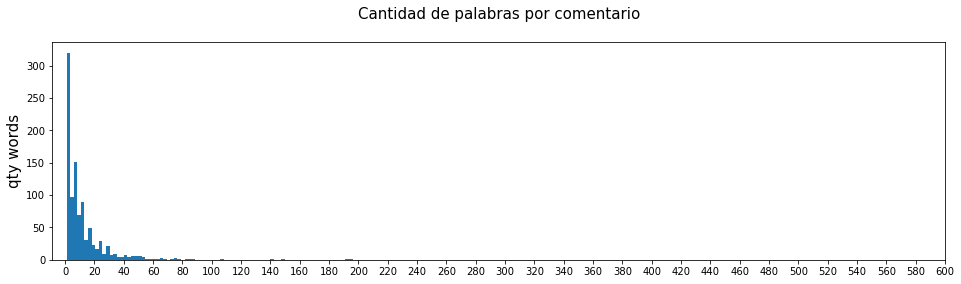

In [153]:
plt.figure(figsize=[16,4])
plt.hist(lengh, bins=80)
plt.ylabel('qty words',fontsize=15)
plt.title('Cantidad de palabras por comentario\n',fontsize=15)
cont=np.linspace(0, 600,31)
plt.xticks(ticks=cont)
plt.show()

In [154]:
maxlen=20 #Lo defino yo en base al ultimo grafico
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [155]:
#Ejemplo de un comentario tokenizado
df['com_tokenizado']=0
df['com_padded']=0
token_all=tokenizer.texts_to_sequences(all_comentarios)
# for i in range(0,len(df.index)): #OPTIMIZARLO CON INDEX? TARDA MUCHO
#     token=tokenizer.texts_to_sequences(all_comentarios[i])
#     df['com_tokenizado'][i]=str(token)
#     df['com_padded'][i]=str(pad_sequences(token_all,padding='post',maxlen=maxlen)[0])


# PREPARING LABELS

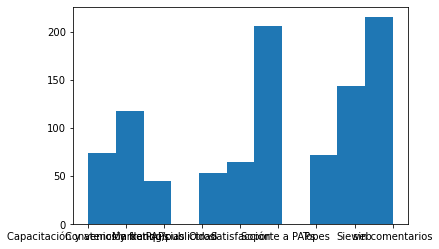

In [156]:
plt.hist(df.category,bins=11)
plt.show()

# Genero el modelo

Hyperparametros:
- dimension de embedding
- cantidad de redes
- canitdad de neuronas por redes
- loss/optimizer
- learning rate
- epoch
    

In [157]:
# Se puede optar por embedding o One Hot Encoding (que cada palabra sea un vector de 0s con 1 uno en la unique word)
# Embedding sirve para cualquier idioma! porque trabaja con tokens y sus relaciones en los inputs, no con texto

In [161]:
# Embedding: OBJETIVO, ES QUE LA RED LSTM CONSIDERE PALABRAS SEMEJANTES, COMO TALES
#lo que hace es generar 1 vector de 0s con solo 1 uno para cada unique word, y el output es el mismo vector, pero algunos 0s cambian de valor!! 
# En el entrenamiento, lo que se hace es que las mismas palabras tengan pesos semejantes segun contexto! Se entrena de forma supervisada, enseñandole que el output, es la frase.

model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim=10000,output_dim=8,input_length=maxlen),
    #10.000 unique words. 16 output interno. Cada palabra va a estar representado con un vector de 16 dimensiones
    #output_dim (hyperparameter):
        #The larger vocabulary you have you want better representation of it - make the layer larger.
        #Si son pocas palabras, y la dim de output es muy grande, seguro hay overfitting.
        #Si el input es muy variado, quiero comprimir mas (el)
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)), #Bidirecional significa que el contexto puede provenir de la derecha o izq del texto. Son 2 LSTM pero en los 2 ordenes!!
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(qty_label,activation='softmax') #Output, 6 dimensiones (triste, happy, etc.)
])

model.compile(
    loss='sparse_categorical_crossentropy',  #Se define el error buscado. 'sparse_categorical_crossentropy' se usa para problemas de clasificacion
    optimizer='adam', #Se encarga de ajustar la velocidad, tiempos, para llegar al punto más optimo, y tener la mayor accuracy (precisión). Ojo con overfitting aca
    metrics='accuracy'
) #loss y optimazer, usan el concepto de Gradient Descent (GD), que es cuan rapido quiero llegar al optimazer

model.optimizer.learning_rate=0.001


#LEARNING RATE: La velocidad en la que quiero que el modelo aprenda. Comparo: error minimo vs Epoch. (creo que se modifica en el optimzaer)
# Si voy muy lento, nunca voy a llegar al error mínimo y hay riesgo de overfitting.
# Si voy muy rapido, los cambios de estado serán tan grandes que nunca voy a llegar al error mínimo. riesgo underfitting

# POSSIBLE LOSSES: is used to find error or deviation in the learning process.
# Es la diferencia entre lo predicto y lo real en cada train. predijo 0,7 y era 0. tiene que ir modificando los 
# pesos de las neuronas para que la próxima vez esté mas cerca de 0

    # mean_squared_error (regression_loss_funcion. va aintentar disminuir el error de la distancia entre predicción-real)
    # mean_absolute_error (regression_loss_funcion)
    # mean_absolute_percentage_error (regression_loss_funcion.
    # mean_squared_logarithmic_error (regression_loss_funcion.)
    # squared_hinge
    # hinge
    # categorical_hinge
    # logcosh
    # huber_loss
    # categorical_crossentropy
    # sparse_categorical_crossentropy: es lo mas comun para clasificacion de numeros enteros categricos
    # binary_crossentropy
    # kullback_leibler_divergence
    # poisson
    # cosine_proximity
    # is_categorical_crossentropy
    
    
# POSSIBLE OPTIMIZER:important process which optimize the input weights by comparing the prediction
# and the loss function
    # SGD 
    # RMSprop 
    # Adagrad 
    # Adadelta 
    # Adam. Es la mas comun
    # Adamax 
    # Nadam 


# POSSIBLE METRICS: is used to evaluate the performance of your model. It is similar to loss function,
# but not used in training process
    # accuracy
    # binary_accuracy
    # categorical_accuracy
    # sparse_categorical_accuracy
    # top_k_categorical_accuracy
    # sparse_top_k_categorical_accuracy
    # cosine_proximity
    # clone_metric

In [162]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 20, 40)            4640      
_________________________________________________________________
bidirectional_9 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 369       
Total params: 94,769
Trainable params: 94,769
Non-trainable params: 0
_________________________________________________________________


In [163]:
def get_sequences(tokenizer,comentario):
    sequences=tokenizer.texts_to_sequences(comentario)
    padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen) #Rellena con 0s para que todos los tweets tengan mismo largo
    return padded

In [164]:
label_train=df[df.data_type=='train']['label']
label_val=df[df.data_type=='val']['label']


sequences_train=tokenizer.texts_to_sequences(comentario_train)
padded_train_seq=pad_sequences(sequences_train,truncating='post',padding='post',maxlen=maxlen)

comentario_val=df[df.data_type=='val']['comentario']
sequences_val=tokenizer.texts_to_sequences(comentario_val)
padded_val_seq=pad_sequences(sequences_val,truncating='post',padding='post',maxlen=maxlen)

In [168]:
# model.fit(X, y, epochs = , batch_size = , validation_data = (x_val, y_val))
h=model.fit(padded_train_seq,np.array(label_train),validation_data=(padded_val_seq,np.array(list(label_val))),
    epochs=7)
#     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)]) #Si al segundo epoch el modelo no ve mejoras en accuracy, frena

Epoch 1/7
18/18 [==============================] - 0s 19ms/step - loss: 1.4990 - accuracy: 0.4211 - val_loss: 1.5265 - val_accuracy: 0.4140
Epoch 2/7
18/18 [==============================] - 0s 16ms/step - loss: 1.4426 - accuracy: 0.4319 - val_loss: 1.5071 - val_accuracy: 0.4194
Epoch 3/7
18/18 [==============================] - 0s 16ms/step - loss: 1.3665 - accuracy: 0.4875 - val_loss: 1.4881 - val_accuracy: 0.4624
Epoch 4/7
18/18 [==============================] - 0s 16ms/step - loss: 1.2214 - accuracy: 0.5717 - val_loss: 1.4769 - val_accuracy: 0.4785
Epoch 5/7
18/18 [==============================] - 0s 17ms/step - loss: 1.1013 - accuracy: 0.6075 - val_loss: 1.5101 - val_accuracy: 0.5054
Epoch 6/7
18/18 [==============================] - 0s 16ms/step - loss: 0.9709 - accuracy: 0.6900 - val_loss: 1.5697 - val_accuracy: 0.4839
Epoch 7/7
18/18 [==============================] - 0s 16ms/step - loss: 0.9514 - accuracy: 0.6828 - val_loss: 1.5282 - val_accuracy: 0.5161


In [169]:

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


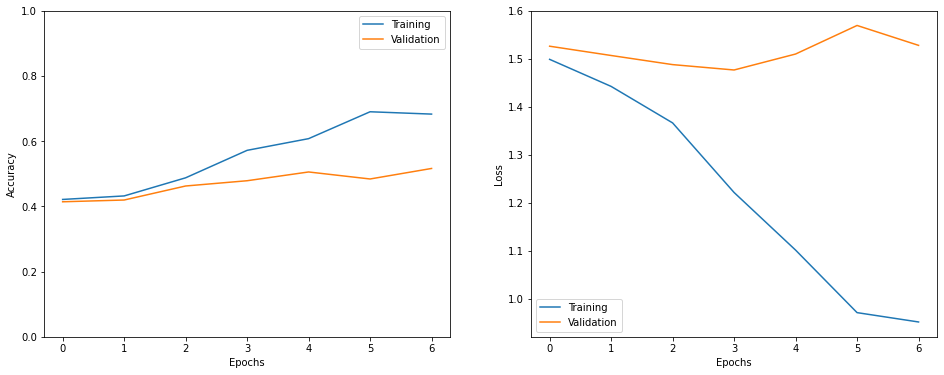

In [170]:
show_history(h)

#Cuando se el train mejora (cae)el loss, pero el loss validation no, sino que sube, eso es un claro Overfitting. 
# Empieza a replicar a la perfección el train

TESTEO CON OTRA MUESTRA REAL

In [171]:
comentario_test=df[df.data_type=='test']['comentario']
sequences_test=tokenizer.texts_to_sequences(comentario_test)
padded_test_seq=pad_sequences(sequences_test,truncating='post',padding='post',maxlen=maxlen)

In [172]:
_=model.evaluate(np.array(padded_test_seq),np.array(y_test))

8/8 [==============================] - 1s 5ms/step - loss: 3.8685 - accuracy: 0.1169


In [173]:
df_test=df[df.data_type=='test'].reset_index()

In [191]:
#Pruebas de testeo sobre comentarios random

rand=random.randint(0,len(df_test)-1) #genero numero random

p=model.predict(np.expand_dims(padded_test_seq[rand],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')] #lo paso a comentario, no numero

print('Sentence:"{}"\nCategory:          "{}"\nPredicted Category "{}"\n\n'.format(
    np.array(df_test['comentario'])[rand],
    (df_test['category'][rand]),
    pred_class))


#PARA 2 CATEGROIAS
# print('Ponderación de los labels sobre la frase:\n{} {} \n{} {}'.format(
#     category[0],[round(p[0],2)],
#     category[1],[round(p[1],2)]))

#PARA 3 CATEGROIAS
print('Ponderación de los labels sobre la frase:\n{} {} \n{} {} \n{} {}\n{} {}\n{} {}\n{} {}\n{} {}\n{} {}'.format(
    category[0],[round(p[0],2)],
    category[1],[round(p[1],2)],
    category[2],[round(p[2],2)],
    category[3],[round(p[3],2)],
    category[4],[round(p[4],2)],
    category[5],[round(p[5],2)],
    category[6],[round(p[6],2)],
    category[7],[round(p[7],2)],


))

Sentence:"mejorar plataforma recargo adquirir paquete movistar volver lento plataforma recargo hasta    minuto perdido"
Category:          "Sieweb"
Predicted Category "Soporte a PAPs"


Ponderación de los labels sobre la frase:
Capacitación y atención de PAPs [0.02] 
Convenios y franquicias  [0.32] 
Marketing/publicidad [0.01]
Otros [0.02]
Satisfacción [0.0]
Soporte a PAPs [0.51]
Topes [0.03]
Sieweb [0.08]


In [192]:
#Predicción de todos los comentarios test
preds=np.argmax(model.predict(padded_test_seq), axis=-1)
preds

df_test['label_predict']=preds
df_test['category_predict']=df_test['label_predict'].replace(index_to_class)

In [193]:
# Vizualizar predicciones
pd.DataFrame(df_test.groupby(['category','category_predict'])['index'].count())

index
category                        category_predict                      
Capacitación y atención de PAPs Capacitación y atención de PAPs  2    
                                Convenios y franquicias          7    
                                Satisfacción                     1    
                                Sieweb                           6    
                                Soporte a PAPs                   3    
Convenios y franquicias         Capacitación y atención de PAPs  2    
                                Convenios y franquicias          13   
                                Sieweb                           9    
                                Soporte a PAPs                   3    
                                Topes                            2    
Marketing/publicidad            Capacitación y atención de PAPs  7    
                                Convenios y franquicias          2    
                                Satisfacción                     1    
                                Soporte a PAPs                   1    
Otros                           Capacitación y atención de PAPs  1    
                                Convenios y franquicias          4    
                                Sieweb                           6    
                                Soporte a PAPs                   2    
Satisfacción                    Capacitación y atención de PAPs  6    
                                Convenios y franquicias          1    
                                Satisfacción                     6    
                                Sieweb                           3    
Sieweb                          Capacitación y atención de PAPs  1    
                                Convenios y franquicias          9    
                                Satisfacción                     2    
                                Sieweb                           19   
                                Soporte a PAPs                   5    
Soporte a PAPs                  Capacitación y atención de PAPs  1    
                                Convenios y franquicias          10   
                                Satisfacción                     1    
                                Sieweb                           5    
                                Soporte a PAPs                   34   
                                Topes                            1    
Topes                           Capacitación y atención de PAPs  5    
                                Convenios y franquicias          3    
                                Sieweb                           8    
                                Soporte a PAPs                   2    
sin comentarios                 Satisfacción                     3    
                                Sieweb                           1    
                                sin comentarios                  50

In [194]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.clf() # Start over
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
cm = confusion_matrix(df_test['category'],df_test['category_predict'])


#CUANDO HAY SOLO 2 CATEGORIAS
# TP=cm[0][0]
# FN=cm[0][1]
# FP=cm[1][0]
# TN=cm[1][1]
# Sens=TP/(TP+FN) #Sensibilidad 
# UnomSp=FP/(FP+TN) #(1-Specify)
# Prec= TP/(TP+FP) # #Precisión
# # Lo mas eficiente es sensibilidad=1, 1-Sepcify=0
# # TP  FN  
# # FP  TN

#CUANDO HAY 3 CATEGORIAS
TP1=cm[0][0]
FN1=cm[0][1]+cm[0][2]
FN1bis=cm[1][2]+cm[2][1]
FP1=cm[1][0]+cm[2][0]
TN1=cm[1][1]+cm[2][2]
Sens=TP1/(TP1+FN1) #Sensibilidad 
UnomSp=FP1/(FP1+TN1+FN1bis) #(1-Specify)
Prec= TP1/(TP1+FP1) # #Precisión
# Lo mas eficiente es sensibilidad=1, 1-Sepcify=0
# TP  FN  
# FP  TN

<Figure size 432x288 with 0 Axes>

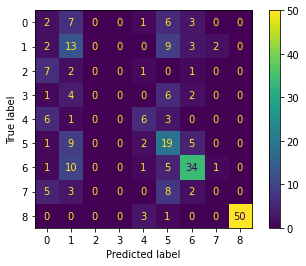

Resultados de Capacitación y atención de PAPs:
De los 9 comentarios test reales "Capacitación y atención de PAPs", el 22.0% fueron correctamente predictos como Capacitación y atención de PAPs (Sensibilidad)
De los 24 comentarios test reales "no Capacitación y atención de PAPs", el 38% fueron erroneamente predictos como Capacitación y atención de PAPs (1-Specify)
De los 11 comentarios test predictos como "Capacitación y atención de PAPs", el 18% fueron correctamente predictos como Capacitación y atención de PAPs (Precisión/Accuracy)


In [195]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 
plt.show()
print(f'Resultados de {category[0]}:')
print(f'De los {TP1+FN1} comentarios test reales "{category[0]}", el {round(Sens,2)*100}% fueron correctamente predictos como {category[0]} (Sensibilidad)')
print(f'De los {TN1+FP1+FN1bis} comentarios test reales "no {category[0]}", el {round(UnomSp*100)}% fueron erroneamente predictos como {category[0]} (1-Specify)') 
print(f'De los {TP1+FP1} comentarios test predictos como "{category[0]}", el {round(Prec*100)}% fueron correctamente predictos como {category[0]} (Precisión/Accuracy)') 

In [197]:
class_to_index 
# sieweb te lo confunde con topes
#Satisfacción con topes y capacitación
#Capacitación con topes

{'Capacitación y atención de PAPs': 0,
 'Convenios y franquicias ': 1,
 'Marketing/publicidad': 2,
 'Otros': 3,
 'Satisfacción': 4,
 'Soporte a PAPs': 5,
 'Topes': 6,
 'Sieweb': 7,
 'sin comentarios': 8}

In [196]:
#GUARDAR EL MODELO! y como volverlo a usar

# from keras.models import load_model

# model.save('modelo_NLP_v1.h5')  # creates a HDF5 file 
# del model  # deletes the existing model


# model = load_model('modelo_NLP_v1.h5') #Carga el modelo guardado para usarlo


In [ ]:
# #Guardar tokenizer!
# import pickle

# # saving
# with open('tokenizer.model_v3', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# import pickle
# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)